Imports:

In [ ]:
from train_for_real import *
import pickle

from torch import nn

#Visulization
#from tqdm import tqdm
from tqdm.notebook import tqdm

# finetuneSAM\models\sam_LoRa.py
from finetuneSAM.models.sam_LoRa import LoRA_Sam

# import plt
import matplotlib.pyplot as plt

from shit import test_model, adjust_lr

from model_settings import get_args


c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit_sam.py:760: UserWarning: Overwriting tiny_vit_5m_224 in registry with finetuneSAM.models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\KU\SamPeft\finetuneSAM\models\sam\modeling\tiny_vit

In [2]:
# model setting
setting = 6

args =  get_args(setting)
sam = load_model(args)


with open('test_data.pkl', 'rb') as file:
    data = pickle.load(file)

train_points = len(data['image'])
checkpoints_path = 'checkpoints'

    
val_percentage = 0.1
val_points = int(train_points*val_percentage)
train_points = train_points - val_points

val_data = {"image":[],"mask":[],"points":[],"p_labels":[]}
for i in range(val_points):
    rnd_indx = np.random.randint(0,len(data["image"])-1)
    val_data["image"].append(data["image"].pop(rnd_indx))
    val_data["mask"].append(data["mask"].pop(rnd_indx))
    val_data['points'].append(data['points'].pop(rnd_indx))
    val_data['p_labels'].append(data['p_labels'].pop(rnd_indx))
    
train_data = data

train_data = EyeData(train_data)

val_data = EyeData(val_data)


#args.finetune_type = 'vanilla'

if args.finetune_type == 'adapter':
        for n, value in sam.named_parameters():
            if "Adapter" not in n: # only update parameters in adapter
                value.requires_grad = False
        print('if update encoder:',args.if_update_encoder)
        print('if image encoder adapter:',args.if_encoder_adapter)
        print('if mask decoder adapter:',args.if_mask_decoder_adapter)
        if args.if_encoder_adapter:
            print('added adapter layers:',args.encoder_adapter_depths)
elif args.finetune_type == 'lora':
    print('if update encoder:',args.if_update_encoder)
    print('if image encoder lora:',args.if_encoder_lora_layer)
    print('if mask decoder lora:',args.if_decoder_lora_layer)
    for n, value in sam.named_parameters():
        value.requires_grad = False
    sam = LoRA_Sam(args,sam,r=2).sam

sam.to('cuda')

# count trainable parameters
total_params = sum(p.numel() for p in sam.parameters() if p.requires_grad)
print('Total trainable parameters:',total_params)

print("Training points:",len(train_data))
print("Validation points:",len(val_data))  

sammy = Sammy(sam, (512,512))

c:\KU\SamPeft\finetuneSAM\models\sam\build_sam.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


if update encoder: True
if image encoder lora: True
if mask decoder lora: True
Total trainable parameters: 115840
Training points: 18
Validation points: 2


In [18]:
# checkpoints\eLdL\+checkpoint_best.pth
with open('checkpoints\eLdL\+checkpoint_best.pth', 'rb') as file:
    model_checkpoint = torch.load(file)
sam.load_state_dict(model_checkpoint)
Sammy = Sammy(sam, (512,512))

C:\Users\newma\AppData\Local\Temp\ipykernel_14232\1951328086.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load(file)


In [28]:
with open('small_data_15.pkl', 'rb') as file:
    small_data_15 = pickle.load(file)

small_data_15 = EyeData(small_data_15)
small_data_15.divide_into_batches(2)

In [34]:
mini_b = small_data_15.batches[0]
imgs,ps,lbls, masks = mini_b['image'],mini_b['points'],mini_b['p_labels'],mini_b['mask']
ret = sammy.predict_w_score(input_images= imgs, points= ps, labels=lbls, masks=masks, visualize=True)
dice, bcee, iou = ret['loss_dice'], ret['loss_bce'], ret['iou']
print('Dice:',dice)
print('BCE:',bcee)
print('IoU:',iou)

Dice: tensor(0.1256, device='cuda:0')
BCE: tensor(0.0834, device='cuda:0')
IoU: tensor([[0.6155],
        [0.6507]], device='cuda:0')


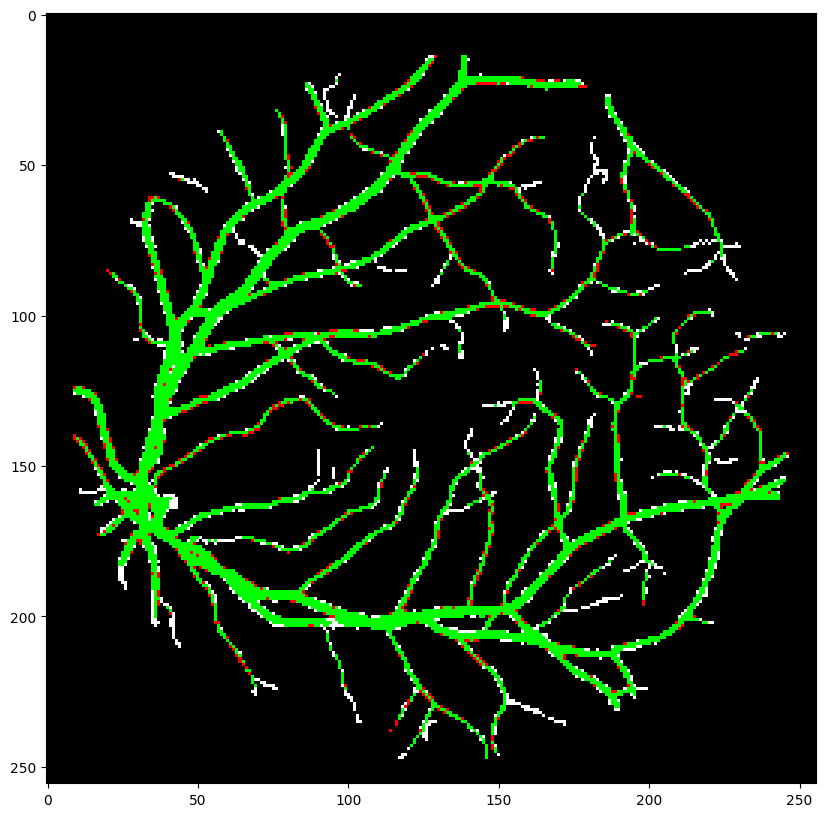

In [35]:
result = ret['visual'][1]
# plot
plt.figure(figsize=(10,10))
plt.imshow(result)